In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [9]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/FERplus/
  inflating: data/FERplus/.gitignore  
  inflating: data/FERplus/fer2013new.csv  
   creating: data/fer2013/
  inflating: data/fer2013/.gitignore  
  inflating: data/fer2013/fer2013.csv  
  inflating: data/fer2013/README     
  inflating: data/fer2013/fer2013.bib  
  inflating: data/fer2013/README.md  


We'll use the custom dataset class that we created in the other notebook

In [10]:
class FERdataset(Dataset):
    def __init__(self, path_fer2013csv, path_fer2013newcsv):
        self.fer2013 = pd.read_csv(path_fer2013csv)
        self.fer2013labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
        self.fer2013new = pd.read_csv(path_fer2013newcsv)
        self.fer2013newlabels = list(self.fer2013new.columns[2:11])
        
    def __getitem__(self, index):
        '''
        returns an image and its fer2013new label as tensors
        '''
        image = self.fer2013['pixels'].iloc[index]
        image = np.fromstring(image, sep=' ').reshape(48, 48)
        image = torch.tensor(image, dtype=torch.float32) / 255
        
        label = torch.tensor(self.fer2013new.iloc[index][2:11].values.astype('float32')) / 10
        
        return image, label
        
    def __len__(self):
        return self.fer2013.shape[0]

In [11]:
path_fer2013csv='data/fer2013/fer2013.csv'
path_fer2013newcsv='data/FERplus/fer2013new.csv'
dataset = FERdataset(path_fer2013csv, path_fer2013newcsv)

We'll also copy over the function that was defined to visualize the data

In [12]:
def display_images_dataloader(num_of_images=5):
    dataloader = DataLoader(dataset, num_of_images, shuffle=True)
    sample_images, sample_labels = next(iter(dataloader))
    print(f'image tensor shape: {sample_images.shape}, label tensor shape: {sample_labels.shape}')
    for i in range(num_of_images):
        image = sample_images[i]
        label = sample_labels[i]
        fig = plt.figure(figsize=(10,5))
        fig.add_subplot(121)
        plt.imshow(image, cmap='gray')
        fig.add_subplot(122)
        plt.bar(dataset.fer2013newlabels, label)
        plt.xticks(rotation=90)
        plt.show()

image tensor shape: torch.Size([5, 48, 48]), label tensor shape: torch.Size([5, 9])


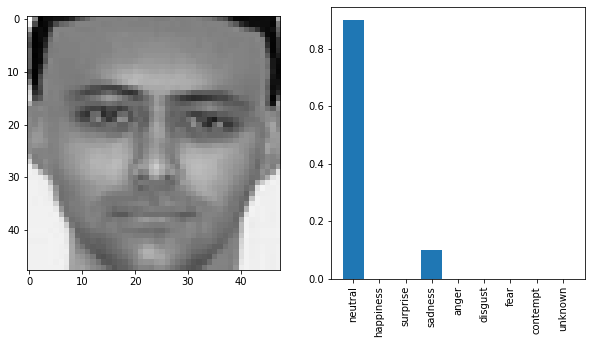

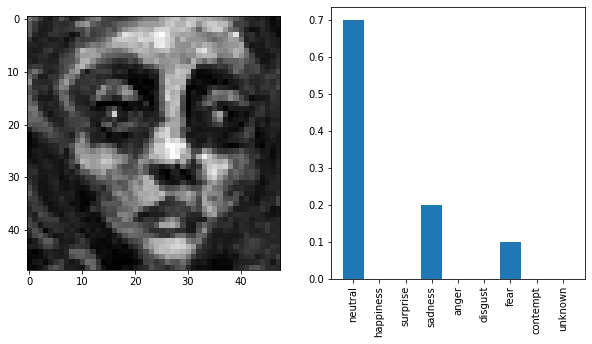

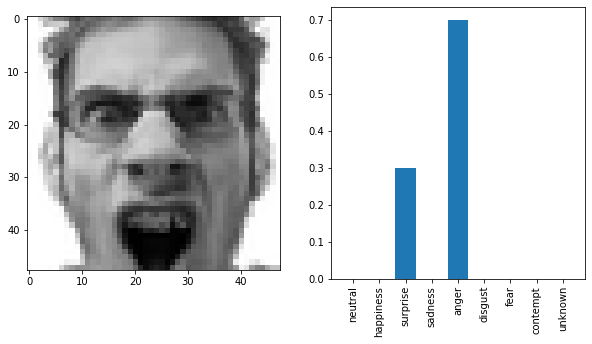

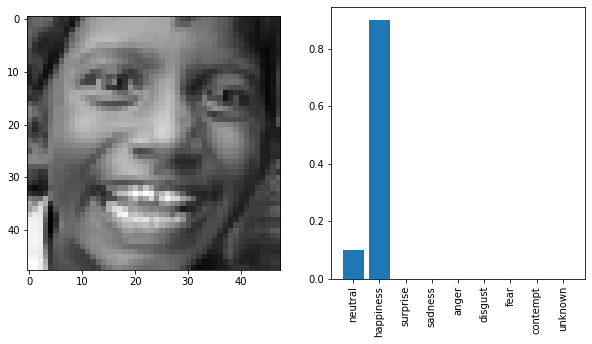

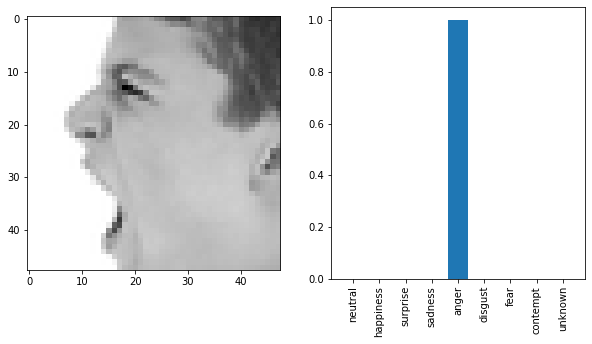

In [13]:
display_images_dataloader()

In [14]:
dataloader = DataLoader(dataset, 2, shuffle=True)
samp_image, samp_label = next(iter(dataloader))

In [15]:
samp_image.shape

torch.Size([2, 48, 48])

In [16]:
samp_image.unsqueeze_(1)
samp_image.shape

torch.Size([2, 1, 48, 48])

In [17]:
samp_label.shape

torch.Size([2, 9])

In [18]:
dataset.fer2013newlabels

['neutral',
 'happiness',
 'surprise',
 'sadness',
 'anger',
 'disgust',
 'fear',
 'contempt',
 'unknown']

### create the train, validation and test sets

In [29]:
from torch.utils.data import random_split

In [30]:
len(dataset)

35887

In [37]:
[int(0.6*len(dataset)), int(0.2*len(dataset)), int(0.2*len(dataset))]

[21532, 7177, 7177]

In [39]:
21532 + 7177 + 7177

35886

In [40]:
traindataset, valdataset, testdataset = random_split(dataset, [int(0.6*len(dataset)), int(0.2*len(dataset)), len(dataset) - (int(0.6*len(dataset)) + int(0.2*len(dataset)))], generator=torch.Generator().manual_seed(42))

In [42]:
print(f'traindataset length: {len(traindataset)}')
print(f'valdataset length: {len(valdataset)}')
print(f'testdataset length: {len(testdataset)}')

traindataset length: 21532
valdataset length: 7177
testdataset length: 7178


### let's create a model and train it

In [152]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.conv2 = nn.Conv2d(10, 10, 3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(10 * 22 * 22, len(dataset.fer2013newlabels))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = torch.softmax(self.fc1(x), dim=1)

        return x



In [153]:
model1 = Model1()
model1

Model1(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4840, out_features=9, bias=True)
)

In [154]:
# parameters
epochs = 5
batch_size = 100

In [155]:
trainloader = DataLoader(traindataset, batch_size, shuffle=True)
valloader = DataLoader(valdataset, batch_size, shuffle=True)

In [156]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters())

In [157]:
torch.cuda.is_available()

True

In [158]:
model1.to(torch.device('cuda'))

Model1(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4840, out_features=9, bias=True)
)

In [159]:
running_loss = []
running_val_loss = []
print_every = 20
for e in range(epochs):
    for i,(images, labels) in enumerate(trainloader):
        images.unsqueeze_(1)
        images = images.to(torch.device('cuda'))
        labels = labels.to(torch.device('cuda'))

        optimizer.zero_grad()
        output = model1(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()


        running_loss.append(loss.item())
        if i%print_every == 0:
            for j,(valimages, vallabels) in enumerate(valloader):
                val_loss_list = []
                valimages.unsqueeze_(1)
                valimages = valimages.to(torch.device('cuda'))
                vallabels = vallabels.to(torch.device('cuda'))

                val_output = model1(valimages)
                val_loss = criterion(val_output, vallabels)

                val_loss_list.append(val_loss.item())

            val_loss_avg = sum(val_loss_list) / len(val_loss_list)

            running_val_loss.append(val_loss_avg)
            print(f'epoch: {e}, iteration: {i}, loss: {loss.item()}, val_loss: {val_loss_avg}')
    

epoch: 0, iteration: 0, loss: 2.1931328773498535, val_loss: 2.1476223468780518
epoch: 0, iteration: 20, loss: 2.082021474838257, val_loss: 2.102480888366699
epoch: 0, iteration: 40, loss: 2.009186029434204, val_loss: 2.058784008026123
epoch: 0, iteration: 60, loss: 2.016111373901367, val_loss: 2.0510075092315674
epoch: 0, iteration: 80, loss: 2.009922981262207, val_loss: 2.067659378051758
epoch: 0, iteration: 100, loss: 2.0111310482025146, val_loss: 2.0368382930755615
epoch: 0, iteration: 120, loss: 2.0130248069763184, val_loss: 2.046797037124634
epoch: 0, iteration: 140, loss: 1.9868935346603394, val_loss: 2.0172765254974365
epoch: 0, iteration: 160, loss: 2.0038697719573975, val_loss: 2.0542657375335693
epoch: 0, iteration: 180, loss: 1.9341158866882324, val_loss: 1.918287754058838
epoch: 0, iteration: 200, loss: 1.9869940280914307, val_loss: 2.064302444458008
epoch: 1, iteration: 0, loss: 1.9471256732940674, val_loss: 1.9277158975601196
epoch: 1, iteration: 20, loss: 1.9760198593139

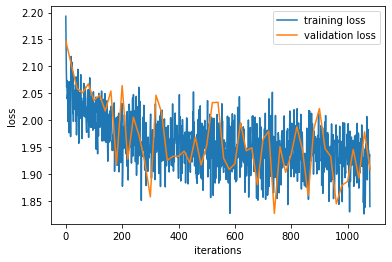

In [160]:
plt.plot(np.arange(len(running_loss)), running_loss, label='training loss')
plt.plot(np.arange(len(running_val_loss))*print_every, running_val_loss, label='validation loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
plt.show()

Note: Validation was done only once every 20 iterations (batch size = 100).

### Let's test some images

In [169]:
testloader = DataLoader(testdataset, 1, shuffle=True)

In [170]:
testimage, testlabel = next(iter(testloader))

In [171]:
testimage.unsqueeze_(1)

tensor([[[[0.9882, 0.9843, 1.0000,  ..., 0.9176, 1.0000, 0.9843],
          [0.9882, 0.9804, 1.0000,  ..., 0.7176, 1.0000, 0.9804],
          [0.9882, 0.9765, 1.0000,  ..., 0.5961, 1.0000, 0.9804],
          ...,
          [0.9882, 0.9882, 0.9922,  ..., 0.6863, 0.8706, 1.0000],
          [0.9882, 0.9882, 0.9882,  ..., 0.6784, 0.9020, 1.0000],
          [0.9882, 0.9882, 0.9843,  ..., 0.6824, 0.9294, 1.0000]]]])

In [172]:
testimage = testimage.to(torch.device('cuda'))

In [173]:
prediction = model1(testimage)

In [174]:
prediction

tensor([[7.6309e-02, 9.2369e-01, 6.7108e-15, 1.0436e-18, 3.6888e-19, 2.8882e-18,
         3.5368e-19, 2.7067e-18, 6.4326e-19]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [175]:
testlabel

tensor([[0.0000, 0.3000, 0.7000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

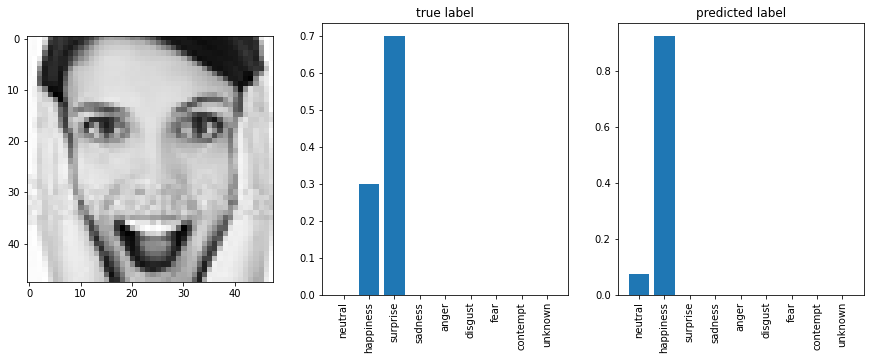

In [176]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(testimage.cpu()[0][0], cmap='gray')
plt.subplot(132)
plt.bar(dataset.fer2013newlabels, testlabel[0])
plt.xticks(rotation=90)
plt.title('true label')
plt.subplot(133)
plt.bar(dataset.fer2013newlabels, prediction.cpu().detach().numpy()[0])
plt.xticks(rotation=90)
plt.title('predicted label')
plt.show()

let's create a function that shows a test image with its actual label and the predicted label 

In [200]:
def show_predictions(num_images=5):
    testloader = DataLoader(testdataset, num_images, shuffle=True)
    testimages, testlabels = next(iter(testloader))
    testimages.unsqueeze_(1)
    testimages = testimages.to(torch.device('cuda'))
    prediction = model1(testimages)
    for i in range(num_images):
        fig = plt.figure(figsize=(15,5))
        fig.add_subplot(131)
        plt.imshow(testimages.cpu()[i][0], cmap='gray')
        fig.add_subplot(132)
        plt.bar(dataset.fer2013newlabels, testlabels[i])
        plt.xticks(rotation=90)
        plt.title('true label')
        fig.add_subplot(133)
        plt.bar(dataset.fer2013newlabels, prediction[i].cpu().detach().numpy())
        plt.xticks(rotation=90)
        plt.title('predicted label')
    plt.show()

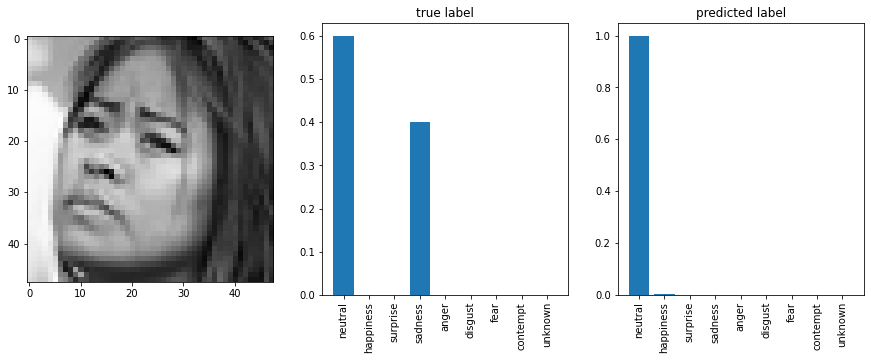

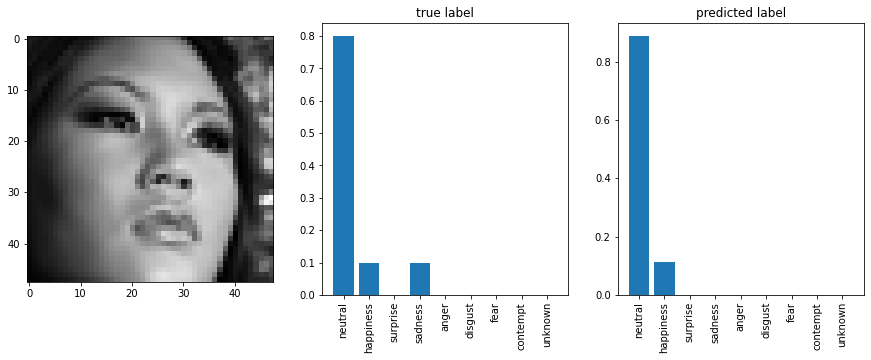

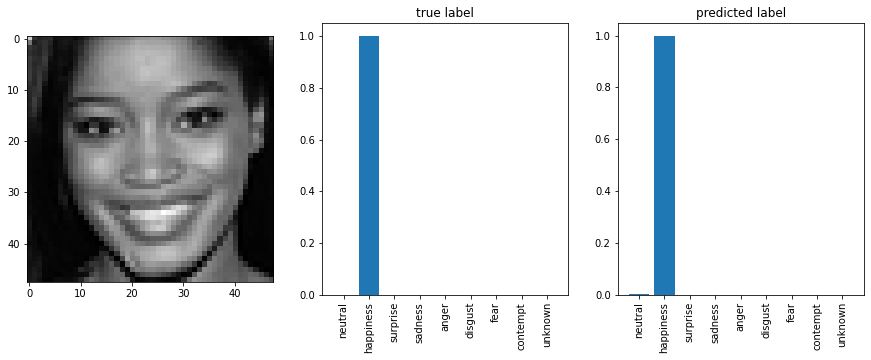

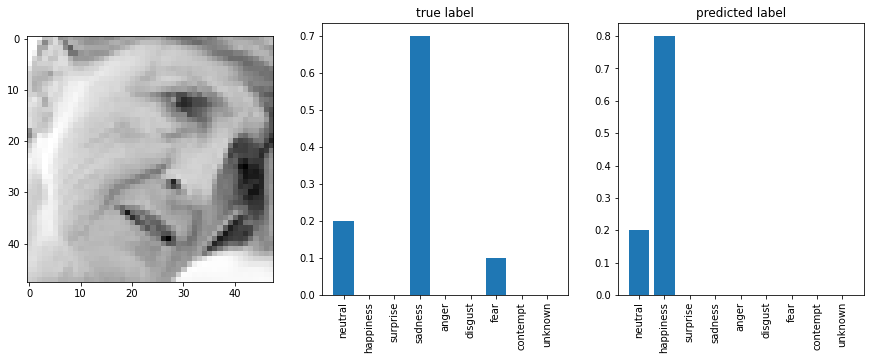

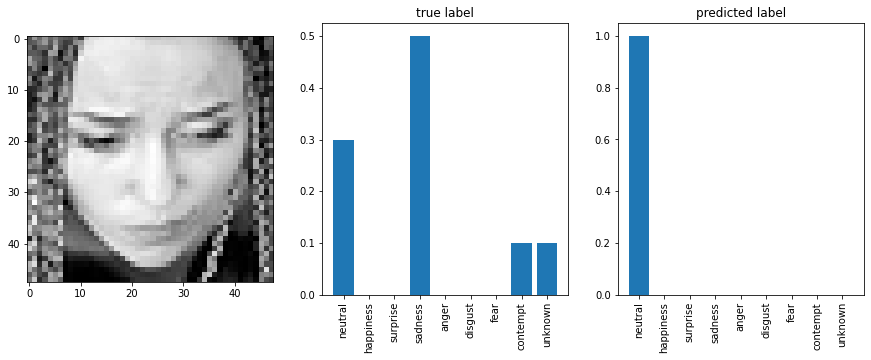

In [201]:
show_predictions()

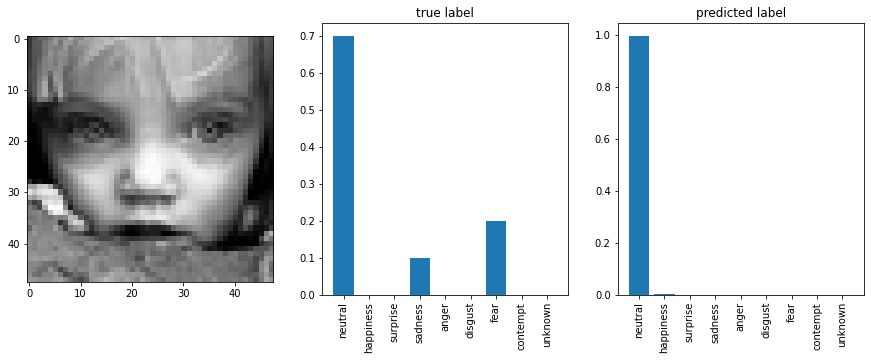

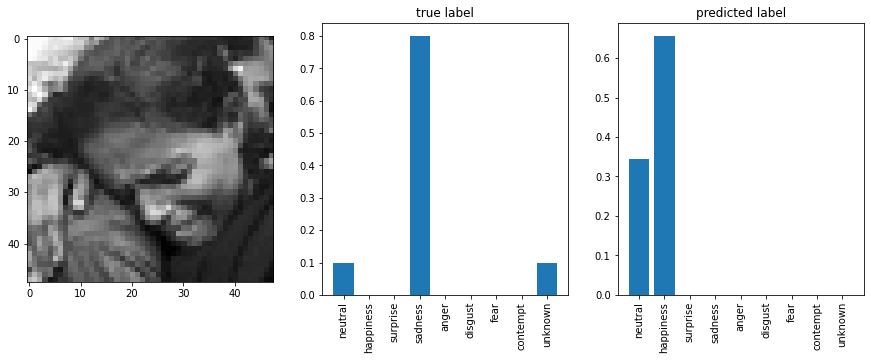

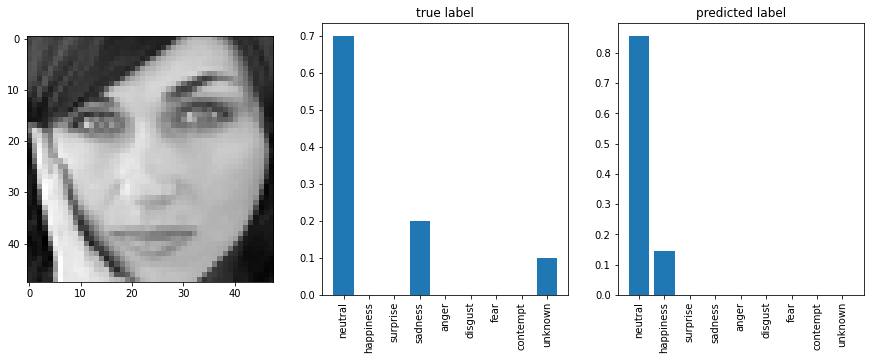

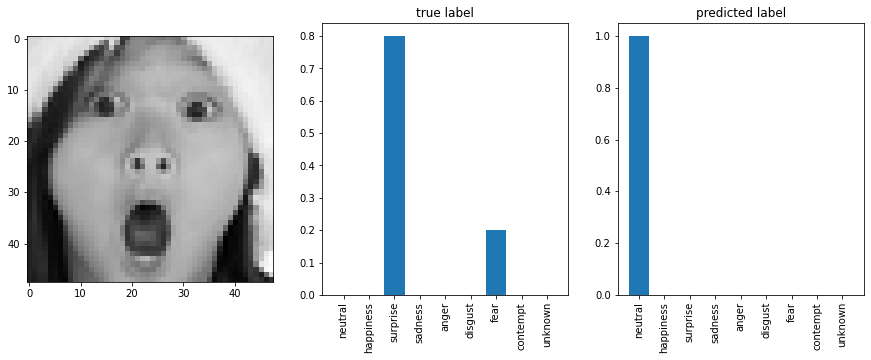

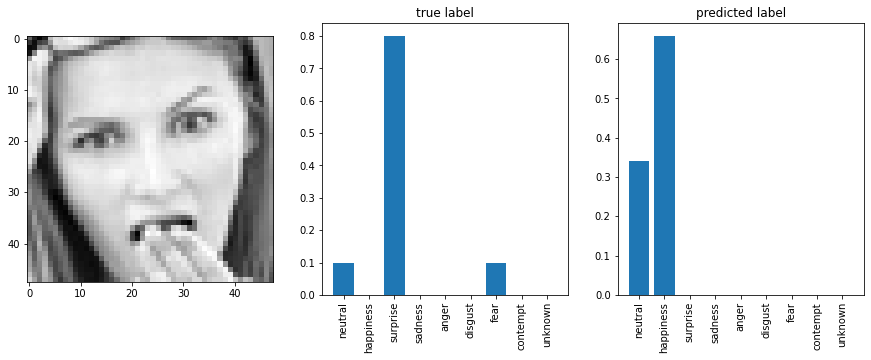

In [202]:
show_predictions()

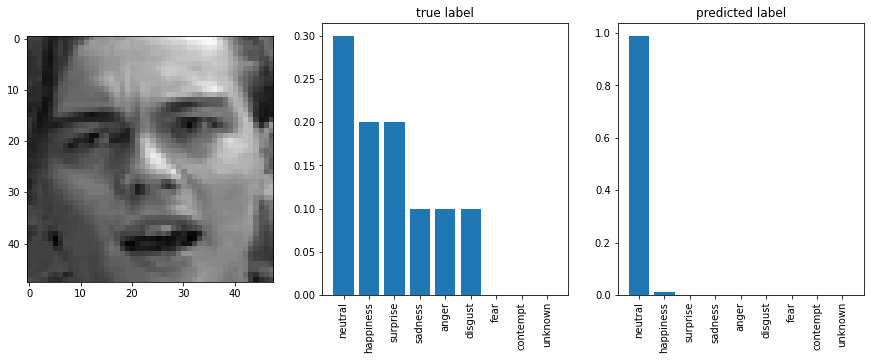

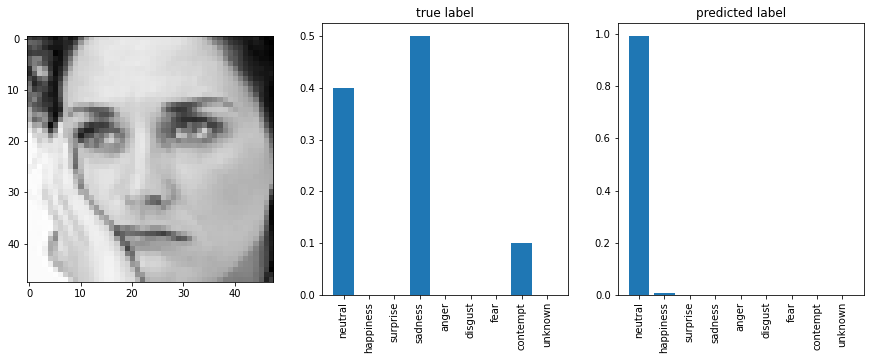

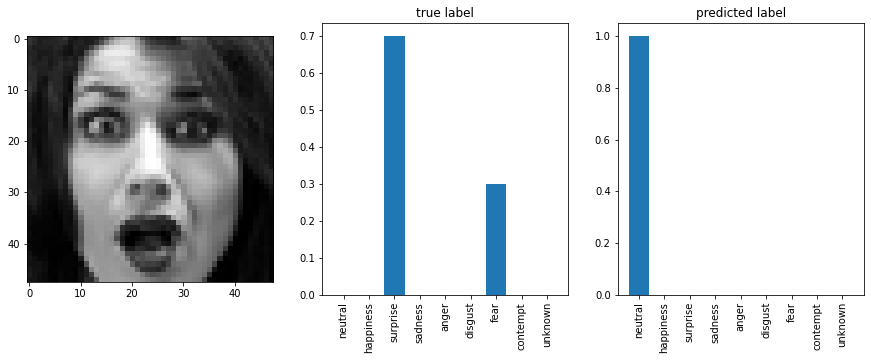

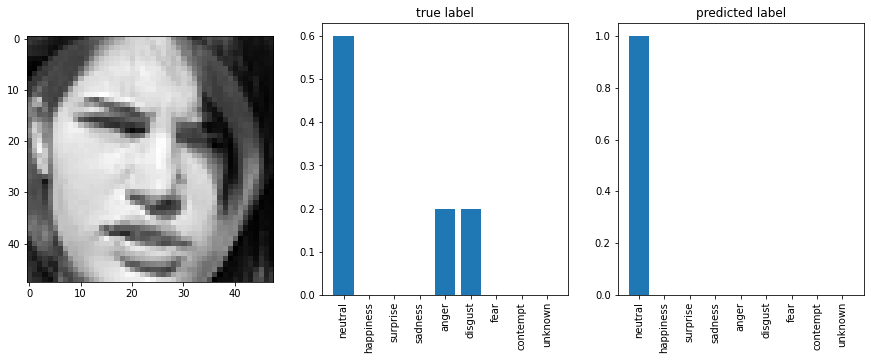

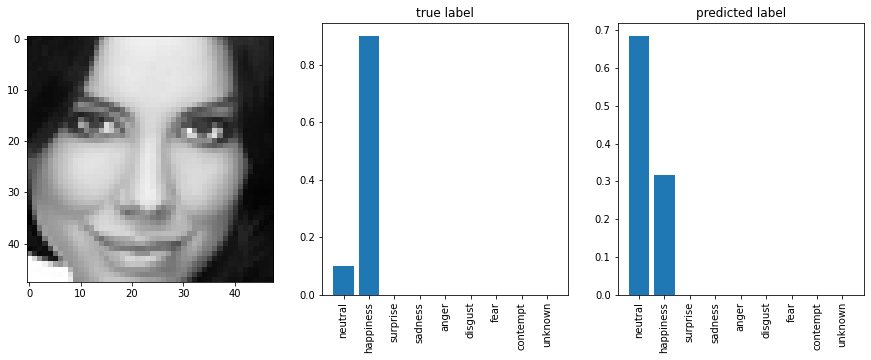

In [203]:
show_predictions()

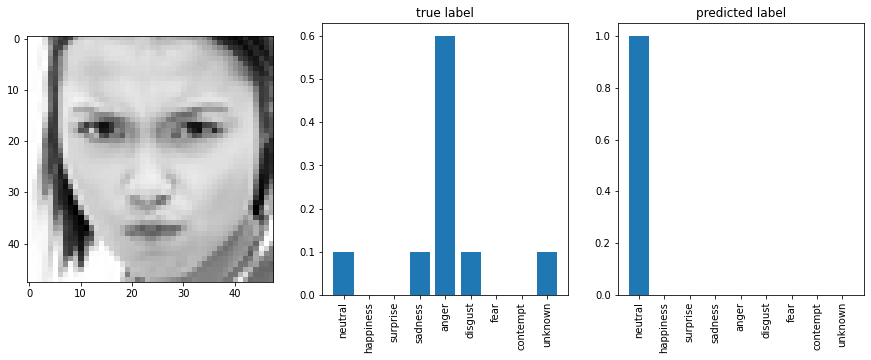

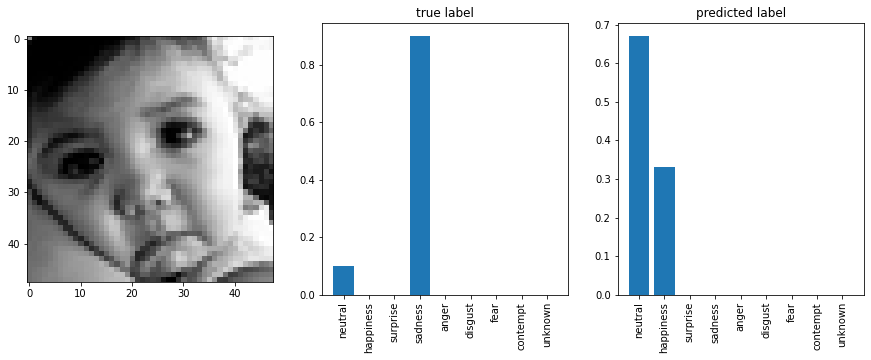

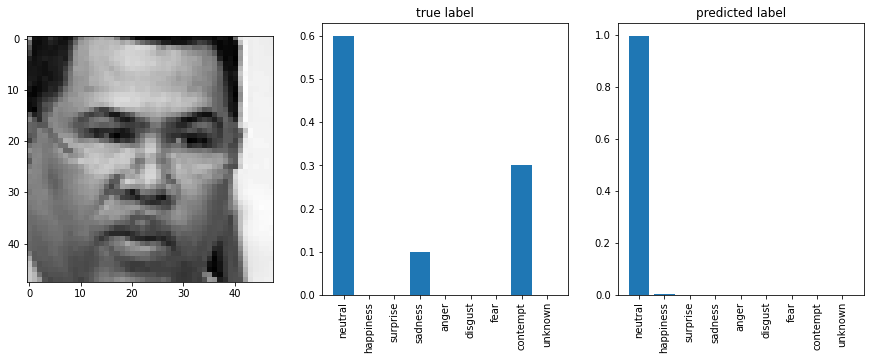

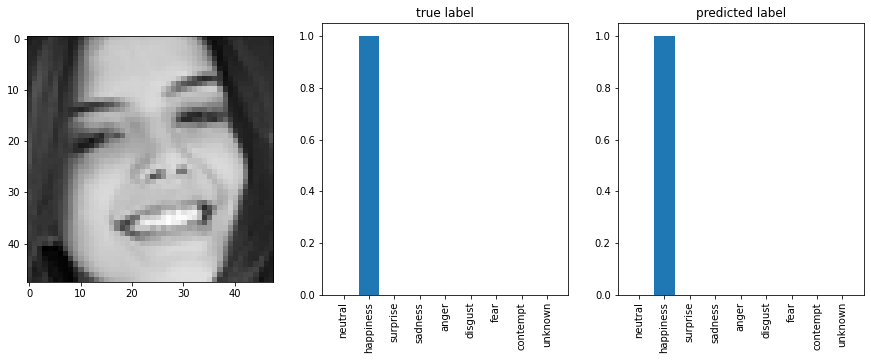

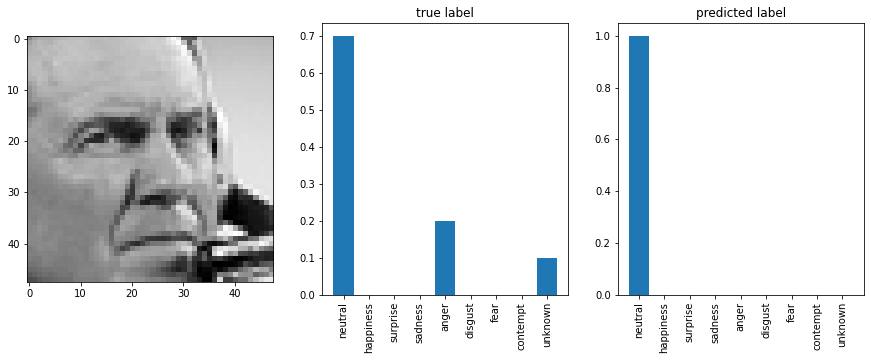

In [204]:
show_predictions()

### Inference

looks like the model has a huge bias toward predicting an image as neutral or happy. But we have to remember that the model is extremely simple.